# 【第一回目　課題１】フレームワークを使わない深層学習 (1): 全結合編

第1回目の課題１では，フレームワークを使わないで，pythonのnumpyのみを用いて簡単なネットワークの順伝搬，逆伝搬，学習を行ってみましょう．

まずは，全結合層＋ReLU＋2乗誤差関数 のネットワークを考えてみます．

全結合層を使って任意の関数の近似を行います．

In [1]:
import math
import numpy as np

全結合層クラスFc を作ってみます．
Fc(入力要素数，出力要素数) とします．

なお，numpyでは，１次元でベクトルを表現すると横ベクトル扱いになってしまうので，
わかりやすくするために，ｎ次元ベクトルを(n,1)の２次元配列で表現することとして，
縦ベクトルで表現とします．

なお，Fcに活性化関数のReLUもまとめて入れてしまいます．
さらに，update, updatem の勾配法によるパラメータの更新の
メソッドも定義します．


In [2]:
class Fc:
  def __init__(self, n_in, n_out, relu=True, seed=0):
    self.n_in=n_in
    self.n_out=n_out
    self.relu=relu
    # w,b は全結合層の学習パラメータ．
    # ReLuも全結合の中にいれてある．
    # ReLU=Trueのときは，Heの初期値．Falseのときは，Xavierの初期値とする．
    # xは直前のforward計算時の入力値．BPの計算時に必要．
    np.random.seed(seed) # 同じ初期値を再現できるように seed を指定します．
    if relu:
      self.w=np.random.normal(0, math.sqrt(2.0/n_in), (n_out, n_in)) # Heの初期値
      self.relu0=None # ReLUの順伝搬時に０以下で値が伝搬されない要素のインデックスを記録．BP時に利用．
    else:
      self.w=np.random.normal(0, math.sqrt(1.0/n_in), (n_out, n_in)) # Xavierの初期値   
    self.b=np.zeros((n_out,1))
    self.x=np.zeros((n_in,1))
    #　誤差逆伝搬(Back-Propagation時の勾配を記録する変数)
    self.dEdx=np.zeros((n_in,1)) # dE/dx を表す　BPの時に直前レイヤに伝わる勾配でδと表現されます．
    self.dEdw=np.zeros((n_out,n_in)) # dE/dw を表す
    self.dEdb=np.zeros((n_out,1)) # dE/db を表す
    self.count=0
    # 以下，MomentamSDGのための設定
    self.mdw=np.zeros((n_out,n_in))
    self.mdb=np.zeros((n_out,1))

# forward は __call__ を使って定義する．単純な 行列＊ベクトル＋ベクトル　の計算．
  def __call__(self,x): 
    self.x = x
    self.y = np.dot(self.w, x) + self.b
    # ReLUは，値が０以下の要素は，０とする．０とした要素のインデックスは relu0に記録し，BP時に勾配を伝搬させない．
    if self.relu:
        self.relu0= self.y<=0
        self.y[self.relu0]=0
    return self.y

# backward は，dE/dy を受け取って，dE/dx を出力．内部では，dE/dw, dE/db を更新
  def backward(self, dEdy):
    # 順伝搬時に値が０以下だった要素は勾配を０として，勾配伝搬しない．
    if self.relu:
        dEdy[self.relu0]=0
    dydx = np.transpose(self.w)  # dWx/dx= np.transpose(W) であることより．
    dydw = np.transpose(self.x)  # dWx/dW= np.transpose(x) 
    # dydb = np.ones((self.n_out,1))   #  db/db = np.ones((n_out,1))　１なので特に計算しない．
    # dEdw, dEdb に勾配を加算．dEdx (δ)は前層へ伝搬する勾配で，backwardの返り値とする．
    self.dEdx = np.dot(dydx, dEdy)
    self.dEdw += np.dot(dEdy, dydw)
    self.dEdb += dEdy
    self.count +=1  # 勾配の平均を取るために，足した勾配のサンプル数を記録．
    return self.dEdx

# 勾配をクリア
  def clear_grad(self):
      self.dEdw=0
      self.dEdb=0
      self.count=0

# 勾配法で重みをアップデート．countで割って，足しこんだ勾配のサンプル数で平均を取る
  def update(self, lr=0.001):
      self.w -= self.dEdw/self.count * lr
      self.b -= self.dEdb/self.count * lr
      self.clear_grad()
    
# 慣性項（モーメンタム項）付きの勾配法
  def updatem(self, lr=0.001, mu=0.9):
      #self.mdw = {自分で実装せよ．}
      #self.mdb = {自分で実装せよ．} 
      self.w += self.mdw
      self.b += self.mdb
      self.clear_grad()

学習モデルのオブジェクトを生成します．
1x10+ReLU +10x10+ReLU + 10x1 の３層とします．

In [3]:
fc1=Fc(1,30)
fc2=Fc(30,30)
fc3=Fc(30,1,False)

Fcクラスの定義が終わったので，次に，近似する関数の定義を行って，学習データ(training data)，検証データ(validation data)を生成します．

In [4]:
def f(x):
    return 0.5*(x-2)**2-5

X_train=np.arange(-10,10,0.01,dtype=np.float32)
Y_train= f(X_train)
# X_train, Y_trainは１次元配列なので，reshapeで ２次元の(n,dim)に変換します．dim=1です．
X_train=np.reshape(X_train,[-1,1])   # (2000,)  -> (2000,1)
Y_train=np.reshape(Y_train,[-1,1]) 
num_train=np.size(X_train)

# テスト用の x も準備します．
X_val=np.arange(-8,8,0.1,dtype=np.float32)
Y_val= f(X_val)
X_val=np.reshape(X_val,[-1,1])
Y_val=np.reshape(Y_val,[-1,1])
num_val=np.size(X_val)

いよいよ，学習ループです．
誤差(loss)のグラフ表示も行います．

loss_val: [[ 225.38199237]]


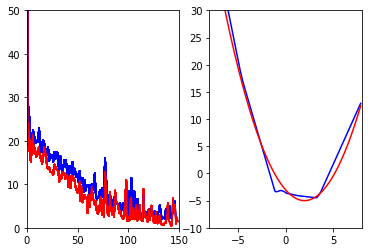

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display

x0=np.reshape(X_val,[-1])

lr=0.001 #学習率
num_epoch=150 # エポック数
num_batch=100 # mini-batch サイズ
#plt.hold(False)
losses=np.array([])
losses_val=np.array([])
ep=np.array([])
# 表示エリアの設定
fig=plt.figure()
fig1 = fig.add_subplot(121)
fig2 = fig.add_subplot(122)
for epoch in range(num_epoch):
# Stochastic Gradient Descent なので，epochごとに学習データをシャッフルします．
    shuffler = np.random.permutation(num_train)
    X_train=X_train[shuffler]
    Y_train=Y_train[shuffler]
    for n in range(0, num_train, num_batch):
        loss=0
        for i in range(num_batch):
          # 順伝搬計算
          y=fc3(fc2(fc1(np.c_[X_train[n+i]])))
          # 誤差微分値，誤差値を計算します． 
          dEdx=y-np.c_[Y_train[n+i]]
          loss+=(dEdx**2)*0.5
          # dEdx (δ)を計算して，逆伝搬します．
          dEdx=fc3.backward(dEdx)
          dEdx=fc2.backward(dEdx)
          dEdx=fc1.backward(dEdx)
        # minibatch の順伝搬，逆伝搬を行ったら，SDGで重みを更新
        fc1.update(lr)
        fc2.update(lr)
        fc3.update(lr)
        # 各epochの最初にグラフ表示を行います．
        if n==0:
          #print "[%d %d] loss: %f" % (epoch,n,loss/num_batch)
          losses=np.append(losses,loss/num_batch)
          ep=np.append(ep,epoch)
          # 検証用データの評価
          loss_val=0
          Y_pred=np.array([])
          for i in range(num_val):
           # 順伝搬計算
            y=fc3(fc2(fc1(np.c_[X_val[i]])))
            Y_pred=np.append(Y_pred,y)
           # 誤差微分値，誤差値 
            dEdx=y-np.c_[Y_val[i]]
            loss_val+=(dEdx**2)*0.5    
            # print y, Y_val[i], (dEdx**2)*0.5
          losses_val=np.append(losses_val, loss_val/num_val)
        
          display.clear_output(wait = True)
          fig1.axis([0, num_epoch, 0, 50])
          fig1.plot(ep,losses,"b")
          fig1.plot(ep,losses_val,"r")
          fig2.axis([-8,8,-10,30])
          y0=np.reshape(Y_pred,[-1])
          fig2.plot(x0,y0,"b")
          fig2.plot(x0,f(x0),"r")
          display.display(fig)
          if epoch<num_epoch-1:
            fig2.cla()
display.clear_output(wait = True)
print "loss_val:",loss_val

### 課題1
以下の小問の(1)-(5)を解答し，さらに(6)-(9)を1つ以上選択し回答すること．

1. 上記のコードにおける全結合層の順伝搬，逆伝搬の計算方法を説明し，上記のコードを実行せよ．
1. 関数$ｆ(x)$を自由に書き換え，実行せよ．
1. モデルパラメータ（例えば，10->30) を変化させて，結果を比較せよ．(特に最終loss値)
1. 学習率を変化させて挙動を観察せよ．
1. モーメンタムSDGに変更して，ノーマルなSDGとの違いを観察せよ．モーメンタムSDGの実装は各自完成させよ．
1. 複数枚の学習画像(2～10枚程度)に対応させて，lossの下がり方の違いについて観察せよ．random shuffleは入れても入れなくてもよい．
1. Adam, AdaGrad のどちらか一方，もしくは両方を実装して比較せよ． 
1. 一定のepoch数，もしくは一定以下の誤差値で，学習率が段階的に下がるようし，効果を検証せよ．
1. 中間層の活性化関数にReLUに加えて，Sigmoidを追加し，(1)ReLu, (2)Sigmoid (3)活性化関数なし　の３通りを比較せよ．

### 【課題1: 任意発展課題】
興味のある人は，例えば，以下のような拡張を行ってみよ．

1. RMSProp,AdaDeltaも実装せよ．
1. 畳み込み層を追加せよ．
1. mini-batch をまとめて，一回で計算するように拡張せよ．dot の代わりに tensordot を使うようにせよ．
1. 上記のmini-batch対応を行った後，cupy ライブラリを使って，GPUに対応させよ．
1. Batch Normalization Layerを追加せよ．
1. SoftMax関数を追加せよ．

1.
このコードでのFC層の順伝播は、入力ベクトルxに重みwを掛け合わせて、バイアス項bを足したものにreluをかけることによって計算する。
逆伝播は、勾配dEdx,dEdw,dEdbを計算し、それらから前の層を平均をとることで計算する。reluは０にするかそのままにするかを順伝播のときに保存しておいたものを使用する

2.
fxを|0.5×(x-2)^2-5|にして計算した。

3.
kadai1-1_3aとkadai1-1_3bで、パラメータ10と30を比較した。validation lossは大きく変化したが、近似した関数の見た目に大きな変化はなかったように思える。

